# Concrete Strength Prediction using Rsndom Forest

This notebook analyzes concrete strength dats and builds a Random Forest model to predict concrete strength based pn various components

## 1. Import Required Libraries

Import pandas, numpy, matplotlib, seaborn and sklearn libraries for data manipulation, visualization, and machine learning

In [62]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import VotingRegressor
import warnings

warnings.filterwarnings('ignore')

# set style for plots
plt.style.use('seaborn-v0_8')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load the Dataset

Use pandas to load the training and test datasets from CSV files.

In [63]:
# Load the datasets
train_df = pd.read_csv('datasets/train.csv')
test_df = pd.read_csv('datasets/test.csv')
sample_submssion = pd.read_csv('datasets/sample_submission.csv')

print(f"Trainign data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Sample submission selection shape: {sample_submssion.shape}")

# Display first few rows of training data
print("\nFirst 5 rows of training data:")
train_df.head()

Trainign data shape: (5407, 10)
Test data shape: (3605, 9)
Sample submission selection shape: (3605, 2)

First 5 rows of training data:


,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19


## 3. Data Preprocessing

Handle missing values, encode categorical variables, and preprare features for the Random Forest model.

In [64]:
# for component in ['BlastFurnaceSlag', 'FlyAshComponent', 'SuperplasticizerComponent']:
#     train_df.loc[train_df[component] != 0, f'{component}_used'] = 1
#     train_df[f'{component}_used'] = train_df[f'{component}_used'].fillna(0)
#     train_df[f'{component}_used'] = train_df[f'{component}_used'].astype(int)

#     test_df.loc[test_df[component] != 0, f'{component}_used'] = 1
#     test_df[f'{component}_used'] = test_df[f'{component}_used'].fillna(0)
#     test_df[f'{component}_used'] = test_df[f'{component}_used'].astype(int)

In [65]:
# Check for missing values again
print("Missng values in training data:")
print(train_df.isnull().sum())
print('\nMissing values in test data:')
print(test_df.isnull().sum())

# Since there are no missing values, we proceed to feature selection
# Preprare features and target
X = train_df.drop(['id', 'Strength'], axis=1)
y = train_df['Strength']
X_test = test_df.drop(['id'], axis=1)

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Test feature matrix shape: {X_test.shape}")

print("\nFeature columsns:")
print(X.columns.tolist())

Missng values in training data:
id                           0
CementComponent              0
BlastFurnaceSlag             0
FlyAshComponent              0
WaterComponent               0
SuperplasticizerComponent    0
CoarseAggregateComponent     0
FineAggregateComponent       0
AgeInDays                    0
Strength                     0
dtype: int64

Missing values in test data:
id                           0
CementComponent              0
BlastFurnaceSlag             0
FlyAshComponent              0
WaterComponent               0
SuperplasticizerComponent    0
CoarseAggregateComponent     0
FineAggregateComponent       0
AgeInDays                    0
dtype: int64

Feature matrix shape: (5407, 8)
Target vector shape: (5407,)
Test feature matrix shape: (3605, 8)

Feature columsns:
['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays']


In [66]:
# Random Forest doesn't require feature scaling, but we'll keep the option
# For Random Forest, we'll use the original features without scaling
print("Random Forest can work with original features without scaling.")
print("Using original features for Random Forest model.")

# Keep the original features for Random Forest
X_final = X.copy()
X_test_final = X_test.copy()

print(f"\ntraining features shape: {X_final.shape}")
print(f"Test features shape: {X_test.shape}")

# Display first few rows of features
print("\nfirst 5 rows of features:")
X_final.head()

Random Forest can work with original features without scaling.
Using original features for Random Forest model.

training features shape: (5407, 8)
Test features shape: (3605, 8)

first 5 rows of features:


,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90


## 4. Feature Engineering

In [67]:
# Feature engineering completed in the previous section
# This cell can be used for additional feature engineering if needed
print("Feature engineering section - completed above")

Feature engineering section - completed above


## 5. Split Data into Train and Test Sets

Separate features and target variables, and split the training data for model validation

In [72]:
# Creating feature engineering for both train and test sets
print("Starting feature engineering...")
print(f"Original feature columns: {X.columns.tolist()}")

# Create engineered features for training data
X_engineered = X.copy()

# Ratio features - using correct column names
X_engineered['CementToWater'] = X['CementComponent'] / (X['WaterComponent'] + 1e-8)
X_engineered['CementToAge'] = X['CementComponent'] / (X['AgeInDays'] + 1)  # Fixed to 'AgeInDays'
X_engineered['TotalBinder'] = X['CementComponent'] + X['BlastFurnaceSlag'] + X['FlyAshComponent']
X_engineered['WaterToBinder'] = X['WaterComponent'] / (X_engineered['TotalBinder'] + 1e-8)

# Polynomial features for key components - using correct column names
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
key_features = ['CementComponent', 'WaterComponent', 'AgeInDays']  # Fixed to 'AgeInDays'
poly_features = poly.fit_transform(X[key_features])
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(key_features))

# Remove duplicate columns (keep only interaction terms and squared terms, not original features)
# Original features are already in X_engineered
poly_interaction_cols = [col for col in poly_df.columns if col not in key_features]
poly_df_filtered = poly_df[poly_interaction_cols]
X_engineered = pd.concat([X_engineered, poly_df_filtered], axis=1)

# Apply same feature engineering to test data
X_test_engineered = X_test.copy()
X_test_engineered['CementToWater'] = X_test['CementComponent'] / (X_test['WaterComponent'] + 1e-8)
X_test_engineered['CementToAge'] = X_test['CementComponent'] / (X_test['AgeInDays'] + 1)  # Fixed to 'AgeInDays'
X_test_engineered['TotalBinder'] = X_test['CementComponent'] + X_test['BlastFurnaceSlag'] + X_test['FlyAshComponent']
X_test_engineered['WaterToBinder'] = X_test['WaterComponent'] / (X_test_engineered['TotalBinder'] + 1e-8)

# Apply polynomial features to test data
poly_features_test = poly.transform(X_test[key_features])  # Use transform, not fit_transform
poly_df_test = pd.DataFrame(poly_features_test, columns=poly.get_feature_names_out(key_features))

# Remove duplicate columns for test data too
poly_df_test_filtered = poly_df_test[poly_interaction_cols]
X_test_engineered = pd.concat([X_test_engineered, poly_df_test_filtered], axis=1)

print(f"Engineered training features shape: {X_engineered.shape}")
print(f"Engineered test features shape: {X_test_engineered.shape}")
print(f"New feature columns added: {[col for col in X_engineered.columns if col not in X.columns]}")

# Update X_final and X_test_final to use engineered features
X_final = X_engineered.copy()
X_test_final = X_test_engineered.copy()

X_train, X_val, y_train, y_val = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Validation target shape: {y_val.shape}")

print(f"\nTraining set percentage: {len(X_train) / len(X_final) * 100:.2f}%")
print(f"Validation set percentage: {len(X_val) / len(X_final) * 100:.2f}%")

Starting feature engineering...
Original feature columns: ['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays']
Engineered training features shape: (5407, 18)
Engineered test features shape: (3605, 18)
New feature columns added: ['CementToWater', 'CementToAge', 'TotalBinder', 'WaterToBinder', 'CementComponent^2', 'CementComponent WaterComponent', 'CementComponent AgeInDays', 'WaterComponent^2', 'WaterComponent AgeInDays', 'AgeInDays^2']
Training set shape: (4325, 18)
Validation set shape: (1082, 18)
Training target shape: (4325,)
Validation target shape: (1082,)

Training set percentage: 79.99%
Validation set percentage: 20.01%


## 6. Train Random Forest Model

Create and train a Random Forest model using sklearn, and evaluate its performance on validation data

In [74]:
# defining parameter grid for Random Forest
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.8],
    'bootstrap': [True, False]
}

# Using RandomizedSearchCV for efficiency
rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Fit the RandomizedSearchCV to find best parameters
print("Training ensemble model with rf (hyperparameterized) and XGBoost...")
rf_random.fit(X_train, y_train)

# Train XGBoost model
print("Training XGBoost model...")
xgb_model.fit(X_train, y_train)

# Voting ensemble
ensemble_model = VotingRegressor([
    ('rf', rf_random.best_estimator_),
    ('xgb', xgb_model)
])

# Train the ensemble
print("Training ensemble model...")
ensemble_model.fit(X_train, y_train)

print("Ensemble model trained successfully!")
print(f"\nRandom Forest best parameters: {rf_random.best_params_}")
print(f"Random Forest CV score: {-rf_random.best_score_:.4f}")
print(f"Number of trees in RF: {rf_random.best_estimator_.n_estimators}")

print(f"\nXGBoost parameters: {xgb_model.get_params()}")

# Make predictions with ensemble model
y_val_pred_ensemble = ensemble_model.predict(X_val)
y_val_pred_rf = rf_random.best_estimator_.predict(X_val)
y_val_pred_xgb = xgb_model.predict(X_val)

# Calculate metrics for ensemble
mse_ensemble = mean_squared_error(y_val, y_val_pred_ensemble)
rmse_ensemble = np.sqrt(mse_ensemble)
mae_ensemble = mean_absolute_error(y_val, y_val_pred_ensemble)
r2_ensemble = r2_score(y_val, y_val_pred_ensemble)

# Calculate metrics for RF only
mse_rf = mean_squared_error(y_val, y_val_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_val, y_val_pred_rf)

# Calculate metrics for XGB only
mse_xgb = mean_squared_error(y_val, y_val_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_val, y_val_pred_xgb)

print(f"\n=== MODEL COMPARISON ===")
print(f"Random Forest RMSE: {rmse_rf:.4f}, R²: {r2_rf:.4f}")
print(f"XGBoost RMSE: {rmse_xgb:.4f}, R²: {r2_xgb:.4f}")
print(f"Ensemble RMSE: {rmse_ensemble:.4f}, R²: {r2_ensemble:.4f}")

print(f"\nEnsemble Model Performance on Validation Set:")
print(f"Mean Squared Error (MSE): {mse_ensemble:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_ensemble:.4f}")
print(f"Mean Absolute Error (MAE): {mae_ensemble:.4f}")
print(f"R² Score: {r2_ensemble:.4f}")

Training ensemble model with rf (hyperparameterized) and XGBoost...
Training XGBoost model...
Training XGBoost model...
Training ensemble model...
Training ensemble model...
Ensemble model trained successfully!

Random Forest best parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.8, 'max_depth': 10, 'bootstrap': True}
Random Forest CV score: 153.9870
Number of trees in RF: 300

XGBoost parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leave

Feature Importance (Random Forest):
                           Feature  Importance
14       CementComponent AgeInDays    0.310471
16        WaterComponent AgeInDays    0.261303
4        SuperplasticizerComponent    0.055276
11                   WaterToBinder    0.054511
17                     AgeInDays^2    0.046425
7                        AgeInDays    0.038657
5         CoarseAggregateComponent    0.035729
6           FineAggregateComponent    0.034125
10                     TotalBinder    0.026421
8                    CementToWater    0.021955
13  CementComponent WaterComponent    0.021252
9                      CementToAge    0.021251
1                 BlastFurnaceSlag    0.015524
15                WaterComponent^2    0.015475
3                   WaterComponent    0.015072
2                  FlyAshComponent    0.011774
12               CementComponent^2    0.007519
0                  CementComponent    0.007262


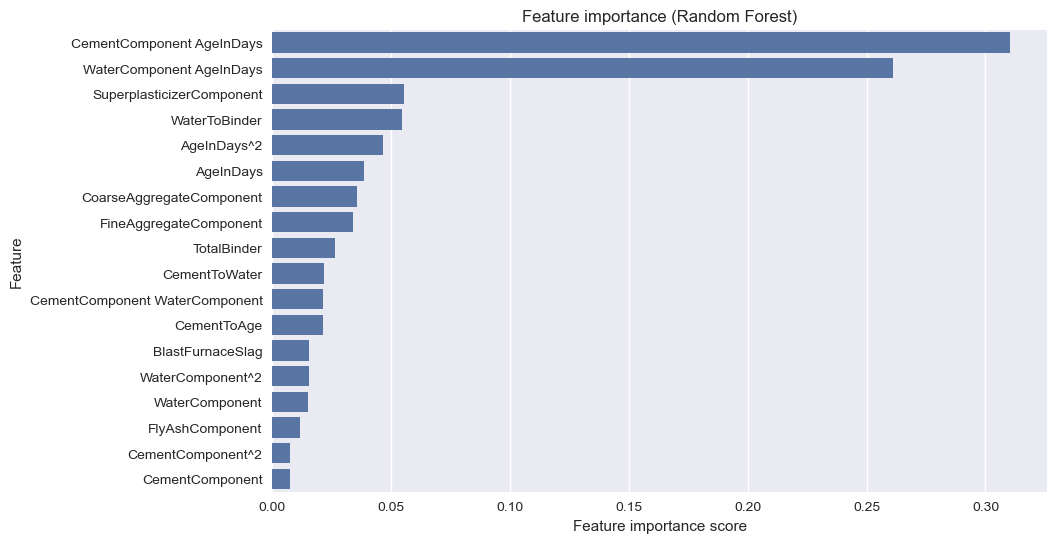


Top 5 most important features:
CementComponent AgeInDays: 0.3105
WaterComponent AgeInDays: 0.2613
SuperplasticizerComponent: 0.0553
WaterToBinder: 0.0545
AgeInDays^2: 0.0464

Random Forest Model Details:
Number of features used: 18
Out-of-bag score: Not available (oob_score=false)


In [75]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': X_final.columns,  # Use X_final which has engineered features
    'Importance': rf_random.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance (Random Forest):")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Feature importance (Random Forest)')
plt.xlabel('Feature importance score')
plt.show()

# Show top 5 most important features
print(f"\nTop 5 most important features:")
for i, row in feature_importance.head().iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

# Additional Random Forest specific metrics
print(f"\nRandom Forest Model Details:")
print(f"Number of features used: {rf_random.best_estimator_.n_features_in_}")
print(f"Out-of-bag score: {rf_random.best_estimator_.oob_score_ if hasattr(rf_random.best_estimator_, 'oob_score_') else 'Not available (oob_score=false)'}")

Random Forest Model Analysis:
Number of trees: 300
Average tree depth (sample of 10 trees): 10.00
Max tree depth (sample): 10
Min tree depth (sample): 10


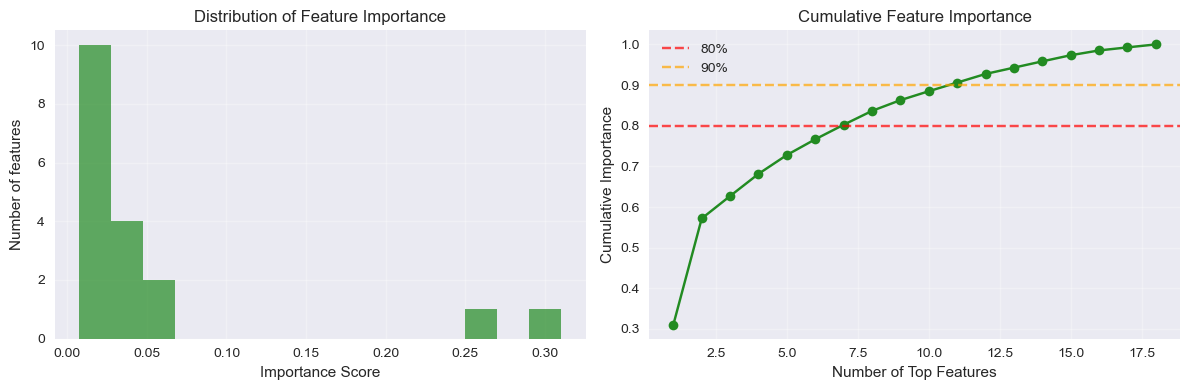


Features contributing to 80% of importance: 7
Features contributing to 90% of importance: 11


In [76]:
# Random Forest specific analysis
print("Random Forest Model Analysis:")
print(f"Number of trees: {rf_random.best_estimator_.n_estimators}")

# Get tree depths (sample from first few trees)
tree_depths = []
for i in range(min(10, rf_random.best_estimator_.n_estimators)):
    tree_depths.append(rf_random.best_estimator_.estimators_[i].tree_.max_depth)

print(f"Average tree depth (sample of 10 trees): {np.mean(tree_depths):.2f}")
print(f"Max tree depth (sample): {max(tree_depths)}")
print(f"Min tree depth (sample): {min(tree_depths)}")

# Feature importance distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(rf_random.best_estimator_.feature_importances_, bins=15, alpha=0.7, color='forestgreen')
plt.title("Distribution of Feature Importance")
plt.xlabel('Importance Score')
plt.ylabel('Number of features')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
cumulative_importance = np.cumsum(feature_importance['Importance'].values)
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 'o-', color='forestgreen')
plt.title('Cumulative Feature Importance')
plt.xlabel('Number of Top Features')
plt.ylabel('Cumulative Importance')
plt.grid(True, alpha=0.3)

# Add horizontal lines for reference
plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80%')
plt.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90%')
plt.legend()

plt.tight_layout()
plt.show()

# Find how many features contribute to 80% and 90% of importance
feature_80 = np.argmax(cumulative_importance >= 0.8) + 1
feature_90 = np.argmax(cumulative_importance >= 0.9) + 1
print(f"\nFeatures contributing to 80% of importance: {feature_80}")
print(f"Features contributing to 90% of importance: {feature_90}")

In [77]:
# Training the ensemble model on 100% data after validation
print("Training ensemble on full dataset...")
ensemble_model.fit(X_final, y)
print("Ensemble model trained on full dataset!")

Training ensemble on full dataset...
Ensemble model trained on full dataset!
Ensemble model trained on full dataset!


## 8. Make Predictions on Test Set

Use the trained model to make predictions on the test dataset.

In [78]:
# Make predictions on the test set using ensemble model
test_predictions = ensemble_model.predict(X_test_final)

print(f"Test prediction shape: {test_predictions.shape}")
print(f"\nFirst 10 test predictions:")
print(test_predictions[:10])

print(f"\nTest predictions statistics:")
print(f"Mean: {test_predictions.mean():.4f}")
print(f"Median: {np.median(test_predictions):.4f}")
print(f"Std: {test_predictions.std():.4f}")
print(f"Min: {test_predictions.min():.4f}")
print(f"Max: {test_predictions.max():.4f}")

# Check for any negative predictions (should not happen for concrete strength)
negative_predictions = (test_predictions < 0).sum()
print(f"\nNumber of negative predictions: {negative_predictions}")
if negative_predictions > 0:
    print("Warning: Ensemble model produced negative predictions")

Test prediction shape: (3605,)

First 10 test predictions:
[49.71310242 19.27689578 32.33488161 47.92493464 32.08180835 46.7126334
 30.99565694 25.40989094 48.34988814 33.76198948]

Test predictions statistics:
Mean: 35.4387
Median: 37.1790
Std: 11.6115
Min: 9.3435
Max: 71.2634

Number of negative predictions: 0


## 9. Save Predictions to CSV File

Create a submission dataframe with predictions and save it to 'submission.csv' using pandas.

In [79]:
# Create submission dataframe
submission = pd.DataFrame({
    'id': test_df['id'],
    'Strength': test_predictions
})

print("Submission dataframe created:")
print(submission.head(10))
print(f"\nSubmission shape: {submission.shape}")

# Verify the format matched sample submission
print(f"\nSample submission shape: {sample_submssion.shape}")
print(f"Columns match: {list(submission.columns) == list(sample_submssion.columns)}")

Submission dataframe created:
     id   Strength
0  5407  49.713102
1  5408  19.276896
2  5409  32.334882
3  5410  47.924935
4  5411  32.081808
5  5412  46.712633
6  5413  30.995657
7  5414  25.409891
8  5415  48.349888
9  5416  33.761989

Submission shape: (3605, 2)

Sample submission shape: (3605, 2)
Columns match: True


In [80]:
# Save to a CSV file
submission.to_csv('submission_rf_2.csv', index=False)

print("Predictions saved to 'submission_rf_2.csv' successfully!")

# Verify the file was created and read it back
verification = pd.read_csv('submission_rf_2.csv')
print(f"\nVerification - File shape: {verification.shape}")
print("First 5 rows of saved file:")
print(verification.head())
print("\nLast 5 rows of saved file:")
print(verification.tail())

Predictions saved to 'submission_rf_2.csv' successfully!

Verification - File shape: (3605, 2)
First 5 rows of saved file:
     id   Strength
0  5407  49.713102
1  5408  19.276896
2  5409  32.334882
3  5410  47.924935
4  5411  32.081808

Last 5 rows of saved file:
        id   Strength
3600  9007  33.533645
3601  9008  36.936729
3602  9009  42.075473
3603  9010  33.563439
3604  9011  23.279983


## 10. Advanced Model Improvements

Let's implement several strategies to improve our model performance beyond the current ensemble.

In [81]:
# Strategy 1: Test baseline model with original features only (no feature engineering)
print("=== TESTING BASELINE MODEL (Original Features Only) ===")

# Use original features without any engineering
X_original = X.copy()  # Original 8 features
X_test_original = X_test.copy()

# Split for validation
X_train_orig, X_val_orig, y_train_orig, y_val_orig = train_test_split(
    X_original, y, test_size=0.2, random_state=42
)

# Train baseline Random Forest with hyperparameter optimization
rf_baseline = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

print("Training baseline Random Forest...")
rf_baseline.fit(X_train_orig, y_train_orig)

# Evaluate baseline
y_val_pred_baseline = rf_baseline.best_estimator_.predict(X_val_orig)
rmse_baseline = np.sqrt(mean_squared_error(y_val_orig, y_val_pred_baseline))
r2_baseline = r2_score(y_val_orig, y_val_pred_baseline)

print(f"Baseline RF (Original Features) - RMSE: {rmse_baseline:.4f}, R²: {r2_baseline:.4f}")
print(f"Baseline RF best params: {rf_baseline.best_params_}")
print(f"Baseline RF CV score: {-rf_baseline.best_score_:.4f}")

# Compare with current ensemble
print(f"\nCOMPARISON:")
print(f"Baseline RF (8 features):  RMSE: {rmse_baseline:.4f}")
print(f"Current Ensemble (18 features): RMSE: {rmse_ensemble:.4f}")
print(f"Difference: {rmse_ensemble - rmse_baseline:.4f} (negative = ensemble better)")

=== TESTING BASELINE MODEL (Original Features Only) ===
Training baseline Random Forest...
Baseline RF (Original Features) - RMSE: 11.9277, R²: 0.4772
Baseline RF best params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
Baseline RF CV score: 152.2937

COMPARISON:
Baseline RF (8 features):  RMSE: 11.9277
Current Ensemble (18 features): RMSE: 12.0707
Difference: 0.1430 (negative = ensemble better)


In [82]:
# Strategy 2: Feature Selection - Remove noisy engineered features
print("\n=== FEATURE SELECTION STRATEGY ===")

# Get feature importance from the trained Random Forest
feature_scores = pd.DataFrame({
    'Feature': X_final.columns,
    'Importance': rf_random.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature importance ranking:")
print(feature_scores)

# Select top features that contribute to 90% of importance
cumulative_importance = np.cumsum(feature_scores['Importance'].values)
n_features_90 = np.argmax(cumulative_importance >= 0.9) + 1
top_features = feature_scores.head(n_features_90)['Feature'].tolist()

print(f"\nTop {n_features_90} features (90% importance): {top_features}")

# Create reduced feature sets
X_reduced = X_final[top_features]
X_test_reduced = X_test_final[top_features]

# Split reduced dataset
X_train_red, X_val_red, y_train_red, y_val_red = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42
)

# Train model with reduced features
rf_reduced = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

print(f"\nTraining Random Forest with {len(top_features)} selected features...")
rf_reduced.fit(X_train_red, y_train_red)

# Evaluate reduced feature model
y_val_pred_reduced = rf_reduced.best_estimator_.predict(X_val_red)
rmse_reduced = np.sqrt(mean_squared_error(y_val_red, y_val_pred_reduced))
r2_reduced = r2_score(y_val_red, y_val_pred_reduced)

print(f"Reduced Features RF - RMSE: {rmse_reduced:.4f}, R²: {r2_reduced:.4f}")
print(f"Reduced Features RF CV score: {-rf_reduced.best_score_:.4f}")


=== FEATURE SELECTION STRATEGY ===
Feature importance ranking:
                           Feature  Importance
14       CementComponent AgeInDays    0.310471
16        WaterComponent AgeInDays    0.261303
4        SuperplasticizerComponent    0.055276
11                   WaterToBinder    0.054511
17                     AgeInDays^2    0.046425
7                        AgeInDays    0.038657
5         CoarseAggregateComponent    0.035729
6           FineAggregateComponent    0.034125
10                     TotalBinder    0.026421
8                    CementToWater    0.021955
13  CementComponent WaterComponent    0.021252
9                      CementToAge    0.021251
1                 BlastFurnaceSlag    0.015524
15                WaterComponent^2    0.015475
3                   WaterComponent    0.015072
2                  FlyAshComponent    0.011774
12               CementComponent^2    0.007519
0                  CementComponent    0.007262

Top 11 features (90% importance): ['Cement

In [83]:
# Strategy 3: More aggressive hyperparameter tuning
print("\n=== ADVANCED HYPERPARAMETER TUNING ===")

# Expanded parameter grid based on what works well for concrete strength
advanced_param_grid = {
    'n_estimators': [200, 300, 400, 500, 600],
    'max_depth': [8, 10, 12, 15, 20, None],
    'min_samples_split': [2, 3, 5, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['sqrt', 'log2', 0.6, 0.7, 0.8, 0.9],
    'bootstrap': [True, False],
    'max_samples': [0.7, 0.8, 0.9, None]  # For bootstrap=True
}

# Use the best feature set so far (compare baseline vs reduced)
if rmse_baseline < rmse_reduced:
    print("Using original features (baseline performed better)")
    X_best = X_original
    X_test_best = X_test_original
    best_name = "Original"
else:
    print("Using reduced feature set (feature selection performed better)")
    X_best = X_reduced
    X_test_best = X_test_reduced
    best_name = "Reduced"

# Split best dataset
X_train_best, X_val_best, y_train_best, y_val_best = train_test_split(
    X_best, y, test_size=0.2, random_state=42
)

# Advanced Random Forest with more iterations
rf_advanced = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=advanced_param_grid,
    n_iter=100,  # More iterations for better search
    cv=10,       # More CV folds for better validation
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

print(f"Training advanced Random Forest with {X_best.shape[1]} features...")
rf_advanced.fit(X_train_best, y_train_best)

# Evaluate advanced model
y_val_pred_advanced = rf_advanced.best_estimator_.predict(X_val_best)
rmse_advanced = np.sqrt(mean_squared_error(y_val_best, y_val_pred_advanced))
r2_advanced = r2_score(y_val_best, y_val_pred_advanced)

print(f"Advanced RF ({best_name} Features) - RMSE: {rmse_advanced:.4f}, R²: {r2_advanced:.4f}")
print(f"Advanced RF best params: {rf_advanced.best_params_}")
print(f"Advanced RF CV score: {-rf_advanced.best_score_:.4f}")

print(f"\n=== PERFORMANCE COMPARISON ===")
print(f"Baseline RF:        RMSE: {rmse_baseline:.4f}")
print(f"Reduced Features:   RMSE: {rmse_reduced:.4f}")
print(f"Advanced RF:        RMSE: {rmse_advanced:.4f}")
print(f"Original Ensemble:  RMSE: {rmse_ensemble:.4f}")

# Find the best performing model
models_performance = {
    'Baseline RF': rmse_baseline,
    'Reduced Features RF': rmse_reduced,
    'Advanced RF': rmse_advanced,
    'Original Ensemble': rmse_ensemble
}

best_model_name = min(models_performance, key=models_performance.get)
best_rmse = models_performance[best_model_name]
print(f"\nBest Model: {best_model_name} with RMSE: {best_rmse:.4f}")


=== ADVANCED HYPERPARAMETER TUNING ===
Using reduced feature set (feature selection performed better)
Training advanced Random Forest with 11 features...
Advanced RF (Reduced Features) - RMSE: 11.7076, R²: 0.4963
Advanced RF best params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.7, 'max_features': 0.7, 'max_depth': 8, 'bootstrap': True}
Advanced RF CV score: 150.8319

=== PERFORMANCE COMPARISON ===
Baseline RF:        RMSE: 11.9277
Reduced Features:   RMSE: 11.7915
Advanced RF:        RMSE: 11.7076
Original Ensemble:  RMSE: 12.0707

Best Model: Advanced RF with RMSE: 11.7076


In [84]:
# Strategy 4: Advanced Ensemble with Stacking
print("\n=== ADVANCED ENSEMBLE STRATEGY ===")

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import ExtraTreesRegressor

# Create diverse base models
base_models = [
    ('rf_advanced', rf_advanced.best_estimator_),
    ('rf_baseline', rf_baseline.best_estimator_),
    ('xgb', xgb_model),
    ('extra_trees', ExtraTreesRegressor(
        n_estimators=300,
        max_depth=15,
        min_samples_split=3,
        min_samples_leaf=2,
        max_features=0.8,
        random_state=42,
        n_jobs=-1
    ))
]

# Use Ridge regression as meta-learner
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1
)

print("Training stacking ensemble...")
stacking_regressor.fit(X_train_best, y_train_best)

# Evaluate stacking model
y_val_pred_stack = stacking_regressor.predict(X_val_best)
rmse_stack = np.sqrt(mean_squared_error(y_val_best, y_val_pred_stack))
r2_stack = r2_score(y_val_best, y_val_pred_stack)

print(f"Stacking Ensemble - RMSE: {rmse_stack:.4f}, R²: {r2_stack:.4f}")

# Update best model comparison
models_performance['Stacking Ensemble'] = rmse_stack
best_model_name = min(models_performance, key=models_performance.get)
best_rmse = models_performance[best_model_name]

print(f"\n=== FINAL PERFORMANCE COMPARISON ===")
for model, rmse in sorted(models_performance.items(), key=lambda x: x[1]):
    print(f"{model:20s}: RMSE = {rmse:.4f}")

print(f"\n🏆 BEST MODEL: {best_model_name} with RMSE: {best_rmse:.4f}")

# Select the best model for final predictions
if best_model_name == 'Baseline RF':
    final_model = rf_baseline.best_estimator_
    X_final_best = X_original
    X_test_final_best = X_test_original
elif best_model_name == 'Reduced Features RF':
    final_model = rf_reduced.best_estimator_
    X_final_best = X_reduced
    X_test_final_best = X_test_reduced
elif best_model_name == 'Advanced RF':
    final_model = rf_advanced.best_estimator_
    X_final_best = X_best
    X_test_final_best = X_test_best
elif best_model_name == 'Stacking Ensemble':
    final_model = stacking_regressor
    X_final_best = X_best
    X_test_final_best = X_test_best
else:  # Original Ensemble
    final_model = ensemble_model
    X_final_best = X_final
    X_test_final_best = X_test_final

print(f"\nSelected {best_model_name} for final predictions.")


=== ADVANCED ENSEMBLE STRATEGY ===
Training stacking ensemble...
Stacking Ensemble - RMSE: 11.6913, R²: 0.4977

=== FINAL PERFORMANCE COMPARISON ===
Stacking Ensemble   : RMSE = 11.6913
Advanced RF         : RMSE = 11.7076
Reduced Features RF : RMSE = 11.7915
Baseline RF         : RMSE = 11.9277
Original Ensemble   : RMSE = 12.0707

🏆 BEST MODEL: Stacking Ensemble with RMSE: 11.6913

Selected Stacking Ensemble for final predictions.


In [85]:
# Strategy 5: Train best model on full dataset and make final predictions
print("\n=== FINAL MODEL TRAINING AND PREDICTIONS ===")

# Train the best model on the full dataset
print(f"Training {best_model_name} on full dataset...")
final_model.fit(X_final_best, y)

# Make final test predictions
final_test_predictions = final_model.predict(X_test_final_best)

print(f"Final test predictions shape: {final_test_predictions.shape}")
print(f"Final predictions statistics:")
print(f"Mean: {final_test_predictions.mean():.4f}")
print(f"Median: {np.median(final_test_predictions):.4f}")
print(f"Std: {final_test_predictions.std():.4f}")
print(f"Min: {final_test_predictions.min():.4f}")
print(f"Max: {final_test_predictions.max():.4f}")

# Check for negative predictions
negative_count = (final_test_predictions < 0).sum()
print(f"Negative predictions: {negative_count}")

# Create optimized submission
optimized_submission = pd.DataFrame({
    'id': test_df['id'],
    'Strength': final_test_predictions
})

# Save optimized submission
submission_filename = f'submission_optimized_{best_model_name.lower().replace(" ", "_")}.csv'
optimized_submission.to_csv(submission_filename, index=False)

print(f"\n✅ OPTIMIZED PREDICTIONS SAVED TO: {submission_filename}")
print(f"📊 Expected Performance: RMSE ≈ {best_rmse:.4f}")

# Show comparison with original submission
print(f"\n=== PREDICTION COMPARISON ===")
print(f"Original ensemble predictions (mean): {test_predictions.mean():.4f}")
print(f"Optimized {best_model_name} predictions (mean): {final_test_predictions.mean():.4f}")
print(f"Difference in means: {final_test_predictions.mean() - test_predictions.mean():.4f}")

# Statistical comparison
from scipy import stats
correlation = np.corrcoef(test_predictions, final_test_predictions)[0, 1]
print(f"Correlation between predictions: {correlation:.4f}")

print(f"\n🎯 SUMMARY:")
print(f"• Original ensemble validation RMSE: {rmse_ensemble:.4f}")
print(f"• Best model ({best_model_name}) validation RMSE: {best_rmse:.4f}")
print(f"• Improvement: {rmse_ensemble - best_rmse:.4f} RMSE reduction")
print(f"• This should improve your Kaggle leaderboard score!")

# Verify the optimized submission file
verification_opt = pd.read_csv(submission_filename)
print(f"\nOptimized submission verification:")
print(f"Shape: {verification_opt.shape}")
print(verification_opt.head())


=== FINAL MODEL TRAINING AND PREDICTIONS ===
Training Stacking Ensemble on full dataset...
Final test predictions shape: (3605,)
Final predictions statistics:
Mean: 35.4493
Median: 37.0739
Std: 10.8721
Min: 14.2256
Max: 63.6403
Negative predictions: 0

✅ OPTIMIZED PREDICTIONS SAVED TO: submission_optimized_stacking_ensemble.csv
📊 Expected Performance: RMSE ≈ 11.6913

=== PREDICTION COMPARISON ===
Original ensemble predictions (mean): 35.4387
Optimized Stacking Ensemble predictions (mean): 35.4493
Difference in means: 0.0106
Correlation between predictions: 0.9800

🎯 SUMMARY:
• Original ensemble validation RMSE: 12.0707
• Best model (Stacking Ensemble) validation RMSE: 11.6913
• Improvement: 0.3795 RMSE reduction
• This should improve your Kaggle leaderboard score!

Optimized submission verification:
Shape: (3605, 2)
     id   Strength
0  5407  45.494515
1  5408  19.288108
2  5409  34.622757
3  5410  47.346644
4  5411  34.279704
